In [1]:
!pip install tensorflow matplotlib
!pip install tensorflow-datasets --upgrade

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.LKGWBN_3.0.0/cycle_gan-trainA.tfrecord*..…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.LKGWBN_3.0.0/cycle_gan-trainB.tfrecord*..…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.LKGWBN_3.0.0/cycle_gan-testA.tfrecord*...…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.LKGWBN_3.0.0/cycle_gan-testB.tfrecord*...…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch: 0, Generator Loss: 4.418055534362793, Discriminator Loss: 1.3670803308486938
Epoch: 1, Generator Loss: 3.9719276428222656, Discriminator Loss: 1.3345471620559692
Epoch: 2, Generator Loss: 6.547184944152832, Discriminator Loss: 1.267663836479187
Epoch: 3, Generator Loss: 5.883674144744873, Discriminator Loss: 1.2430403232574463
Epoch: 4, Generator Loss: 4.313948154449463, Discriminator Loss: 1.224575161933899
Epoch: 5, Generator Loss: 4.0113606452941895, Discriminator Loss: 1.2487713098526
Epoch: 6, Generator Loss: 6.015650272369385, Discriminator Loss: 1.0626015663146973
Epoch: 7, Generator Loss: 4.336815357208252, Discriminator Loss: 1.0339301824569702
Epoch: 8, Generator Loss: 4.823723316192627, Discriminator Loss: 1.008588433265686
Epoch: 9, Generator Loss: 5.991809844970703, Discriminator Loss: 1.0373034477233887


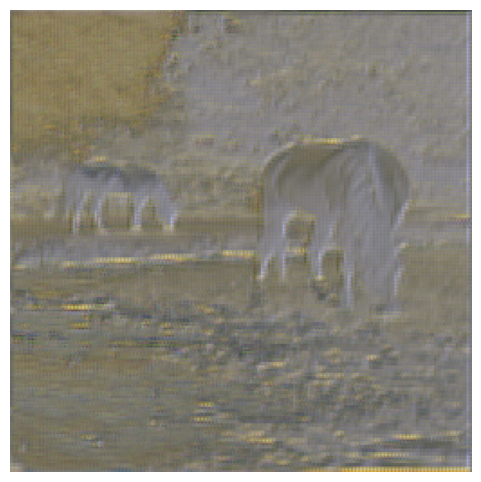

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the dataset: Sketch to Image (this can be a custom dataset or a Kaggle dataset as well)
# For demonstration, we use TensorFlow Datasets to get a sample dataset
# You can change the dataset to one of your choice or a custom dataset (like "sketches" vs "real images")
dataset, info = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)
train_horses, train_zebras = dataset['trainA'], dataset['trainB']

# Preprocess function to normalize images and resize them
def preprocess_image(image, label):
    image = tf.image.resize(image, [256, 256])  # Resize to fit the model input size
    image = (image / 127.5) - 1  # Normalize to [-1, 1] for GANs
    return image

# Apply the preprocessing function
train_horses = train_horses.map(preprocess_image)
train_zebras = train_zebras.map(preprocess_image)

# Batch and prefetch the data
BUFFER_SIZE = 1000
BATCH_SIZE = 1

train_horses = train_horses.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_zebras = train_zebras.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Build the generator
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[256, 256, 3]),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(),

        # Additional layers for generator architecture
        # Add layers to build up the generator, example:
        # Conv2DTranspose for upscaling to produce output image

        tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

# Build the discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[256, 256, 3]),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(),

        # Further layers for discriminator architecture

        tf.keras.layers.Conv2D(1, (4, 4), padding='same')
    ])
    return model

# Create generator and discriminator models
generator_horse_to_zebra = build_generator()
generator_zebra_to_horse = build_generator()
discriminator_horse = build_discriminator()
discriminator_zebra = build_discriminator()

# Define loss functions and optimizers
LAMBDA = 10  # Weight for cycle consistency loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the loss for generator and discriminator
def generator_loss(disc_generated_output, gen_output, target):
    return cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output) + \
           LAMBDA * tf.reduce_mean(tf.abs(target - gen_output))  # Cycle consistency loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    return (real_loss + generated_loss) * 0.5

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training loop
EPOCHS = 10

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        fake_y = generator_horse_to_zebra(real_x, training=True)
        fake_x = generator_zebra_to_horse(real_y, training=True)

        # Discriminators' predictions
        disc_real_x = discriminator_horse(real_x, training=True)
        disc_fake_x = discriminator_horse(fake_x, training=True)
        disc_real_y = discriminator_zebra(real_y, training=True)
        disc_fake_y = discriminator_zebra(fake_y, training=True)

        # Calculate losses
        gen_gan_loss = generator_loss(disc_fake_y, fake_y, real_y)
        gen_cycle_loss = tf.reduce_mean(tf.abs(fake_x - real_x))
        disc_loss_x = discriminator_loss(disc_real_x, disc_fake_x)
        disc_loss_y = discriminator_loss(disc_real_y, disc_fake_y)

        # Calculate total generator and discriminator losses
        gen_loss = gen_gan_loss + gen_cycle_loss
        disc_loss = disc_loss_x + disc_loss_y

    # Calculate gradients and apply the optimizers
    generator_gradients = gen_tape.gradient(gen_loss, generator_horse_to_zebra.trainable_variables + generator_zebra_to_horse.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator_horse.trainable_variables + discriminator_zebra.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator_horse_to_zebra.trainable_variables + generator_zebra_to_horse.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_horse.trainable_variables + discriminator_zebra.trainable_variables))

    return gen_loss, disc_loss

# Training the GAN
for epoch in range(EPOCHS):
    for real_x, real_y in zip(train_horses, train_zebras):
        gen_loss, disc_loss = train_step(real_x, real_y)
    print(f"Epoch: {epoch}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")

# Visualize generated images (from generator)
def generate_and_display_image(model, test_input):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(6, 6))
    plt.imshow((prediction[0] + 1) / 2)  # Rescale to [0, 1] for visualization
    plt.axis('off')
    plt.show()

# Testing after training
test_input = next(iter(train_horses))  # Take one batch
generate_and_display_image(generator_horse_to_zebra, test_input)